# NBA Player Stats Prediction

**Team Members:** Ryan, Momoka, Jesus, Angel, Harshil   
**Course:** CS4661 - Introduction to Data Science  
**Objective:** Predict NBA player statistics using machine learning

---

## Project Overview

This notebook demonstrates a complete machine learning pipeline for predicting NBA player statistics:
- **Target Variables:** PTS (total points scored) and team win classifiction
- **Models:** Linear Regression, Random Forest, Gradient Boosting
- **Approach:** Modular, reusable functions for scalability and maintainability

## 1. Imports and Setup

In [1]:
import data_utils
import training

## 2. Load and Explore Data

In [2]:
# Load dataset (only need to do this once!)
player_stats_df = data_utils.load_nba_data()

Path to dataset files: /Users/ryan/.cache/kagglehub/datasets/eduardopalmieri/nba-player-stats-season-2425/versions/37

Available CSV files: ['database_24_25.csv']

DATASET OVERVIEW

Dataset shape: (16512, 25)

Column names:
['Player', 'Tm', 'Opp', 'Res', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', 'Data']

First few rows:
          Player   Tm  Opp Res     MP  FG  FGA    FG%  3P  3PA  ...  DRB  TRB  \
0   Jayson Tatum  BOS  NYK   W  30.30  14   18  0.778   8   11  ...    4    4   
1  Anthony Davis  LAL  MIN   W  37.58  11   23  0.478   1    3  ...   13   16   
2  Derrick White  BOS  NYK   W  26.63   8   13  0.615   6   10  ...    3    3   
3   Jrue Holiday  BOS  NYK   W  30.52   7    9  0.778   4    6  ...    2    4   
4  Miles McBride  NYK  BOS   L  25.85   8   10  0.800   4    5  ...    0    0   

   AST  STL  BLK  TOV  PF  PTS  GmSc        Data  
0   10    1    1    1   1   37  38.1  2024-10-

## 3. Predict Points Scored (PTS)

Points scored (PTS) represents the number of successful points made by a player in a game.


################################################################################
# PREDICTION PIPELINE FOR: PTS
################################################################################

Target variable: PTS
Feature variables (16 total): ['MP', 'FGA', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']
Final dataset shape: X=(16512, 16), y=(16512,)

Train set: 9907 samples
Test set: 6605 samples

MODEL TRAINING FOR PTS

--------------------------------------------------------------------------------
Model: Linear Regression
--------------------------------------------------------------------------------


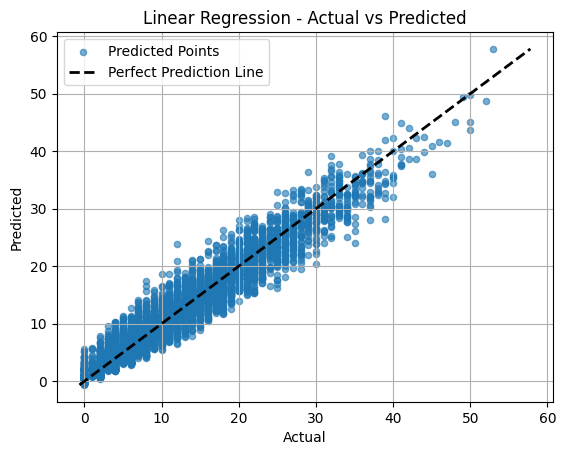

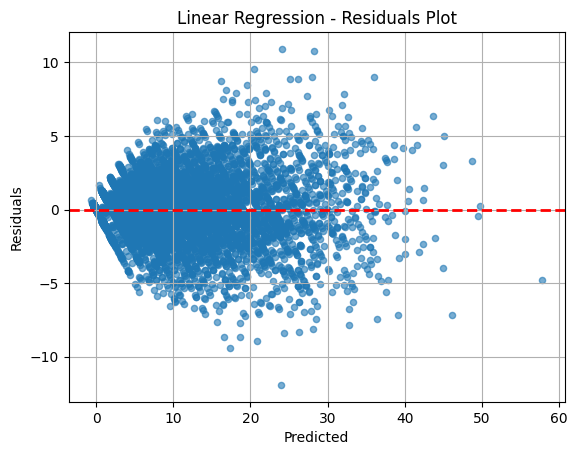

RMSE: 2.1743
MAE: 1.5885
R²: 0.9391

Feature Coefficients:
  MP: 0.2254
  FGA: 6.5157
  3P: 4.6443
  3PA: -3.6856
  3P%: -0.0842
  FT: 1.9715
  FTA: 0.2723
  FT%: 0.0838
  ORB: -0.0956
  DRB: 0.1303
  TRB: 0.0647
  AST: -0.0781
  STL: 0.0363
  BLK: 0.0855
  TOV: -0.0170
  PF: -0.0298

--------------------------------------------------------------------------------
Model: Random Forest
--------------------------------------------------------------------------------


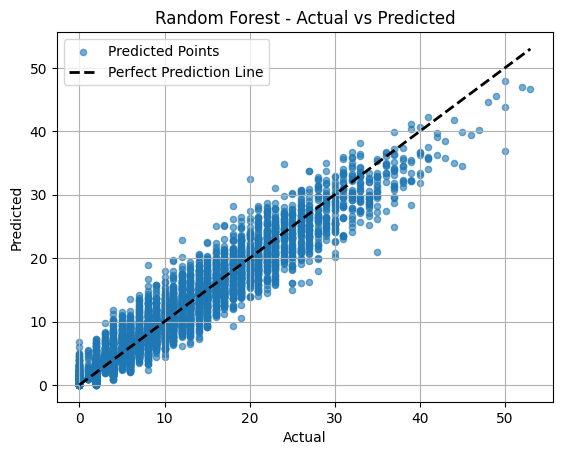

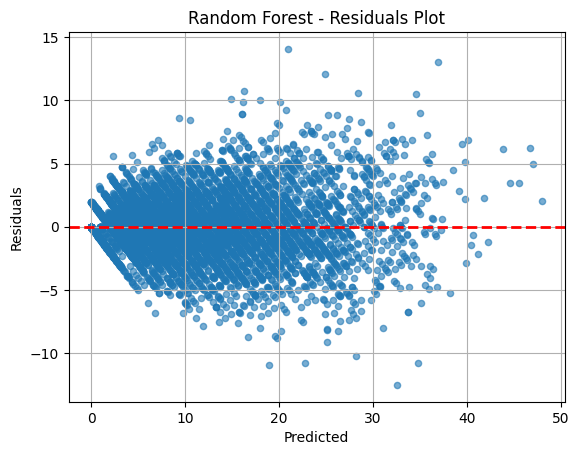

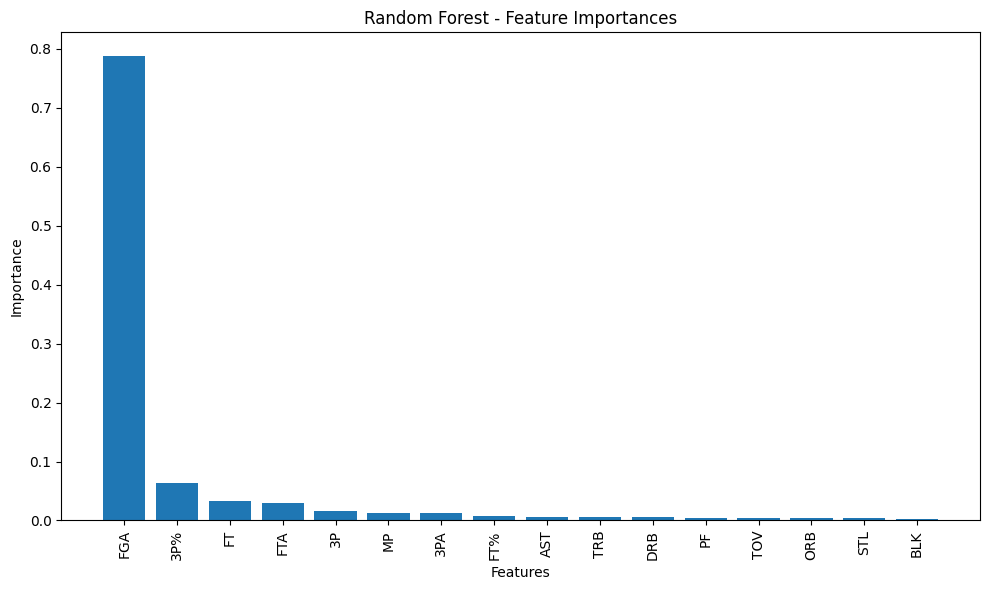

RMSE: 2.3868
MAE: 1.7168
R²: 0.9266

Feature Importances:
  MP: 0.0134
  FGA: 0.7884
  3P: 0.0162
  3PA: 0.0132
  3P%: 0.0634
  FT: 0.0325
  FTA: 0.0297
  FT%: 0.0076
  ORB: 0.0037
  DRB: 0.0053
  TRB: 0.0055
  AST: 0.0058
  STL: 0.0035
  BLK: 0.0030
  TOV: 0.0042
  PF: 0.0046

--------------------------------------------------------------------------------
Model: Gradient Boosting
--------------------------------------------------------------------------------


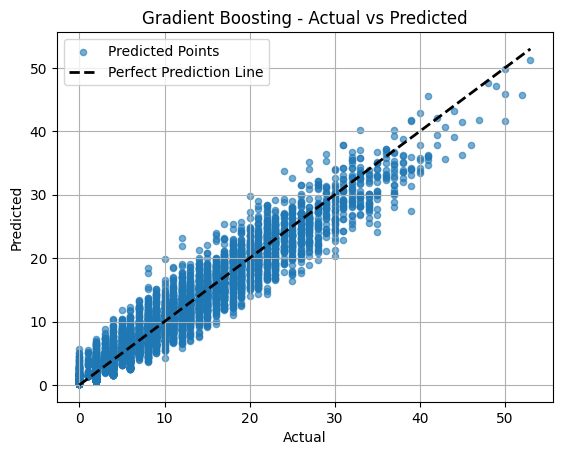

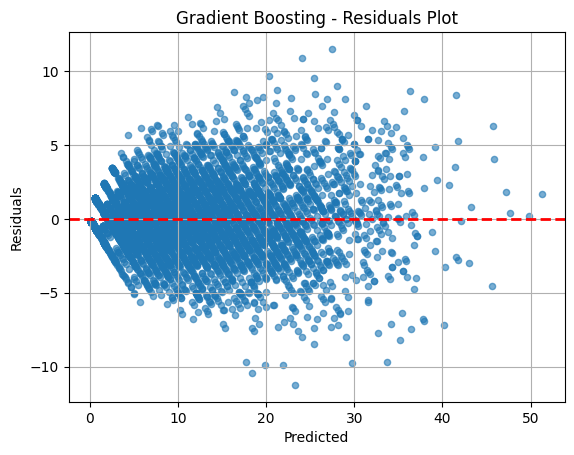

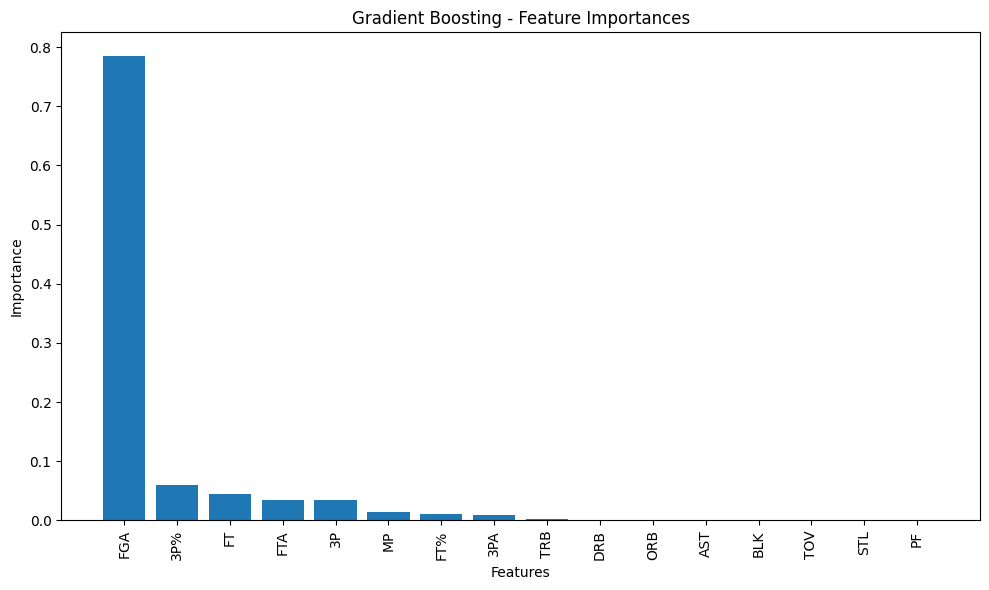

RMSE: 2.2749
MAE: 1.6624
R²: 0.9333

Feature Importances:
  MP: 0.0148
  FGA: 0.7857
  3P: 0.0340
  3PA: 0.0098
  3P%: 0.0608
  FT: 0.0448
  FTA: 0.0353
  FT%: 0.0108
  ORB: 0.0002
  DRB: 0.0006
  TRB: 0.0027
  AST: 0.0002
  STL: 0.0001
  BLK: 0.0001
  TOV: 0.0001
  PF: 0.0001

SUMMARY OF RESULTS FOR PTS

                          RMSE         MAE        R²
Linear Regression     2.174299    1.588467  0.939073
Random Forest         2.386818    1.716802  0.926581
Gradient Boosting     2.274935    1.662439  0.933303

Best Model (by R²): Linear Regression
Best Model (by RMSE): Linear Regression
Best Model (by MAE): Linear Regression


({'Linear Regression': {'RMSE': np.float64(2.174298662942923),
   'MAE': 1.588466536068367,
   'R²': 0.9390734842086711},
  'Random Forest': {'RMSE': np.float64(2.3868183618586643),
   'MAE': 1.716802422407267,
   'R²': 0.9265813007880593},
  'Gradient Boosting': {'RMSE': np.float64(2.27493488059965),
   'MAE': 1.6624387004339314,
   'R²': 0.9333030638190561}},
                        RMSE       MAE        R²
 Linear Regression  2.174299  1.588467  0.939073
 Random Forest      2.386818  1.716802  0.926581
 Gradient Boosting  2.274935  1.662439  0.933303)

In [3]:
# Run complete pipeline for FG prediction
training.predict_target(player_stats_df, "PTS", classification=False)

## 4. Next Steps (To Be Completed)

### TODO List for Team:

1. **Exploratory Data Analysis (EDA)** - Assigned to: Angel (Week 1-2)
   - Distribution plots for PTS (player-level)
   - Distribution plots for aggregated team statistics (team-level)
   - Correlation heatmaps (both player and team level)
   - Win vs Loss feature comparisons
   - Temporal trends

2. **Feature Engineering** - Assigned to: Ryan + Momoka (Week 1)
   - Encode categorical variables (Tm, Opp, Res)
   - Create derived features (shooting efficiency, etc.)
   - Stretch: Rolling averages for player form
   - Stretch goal: PCA (Dimensionality Reduction)

3. **Team Win Prediction (Classification)** - Assigned to: **Ryan** (Week 1-2)
   - Transform player-level data to team-game level using aggregation
   - Binary classification models (Logistic Regression, Random Forest Classifier, Gradient Boosting Classifier)
   - Evaluate with accuracy, precision, recall, F1-score, ROC curves
   - Compare classification performance across models
   - **Deliverable:** New prediction pipeline for binary classification + results comparison

4. **Hyperparameter Tuning & Additional Modeling** - Assigned to: Jesus (Week 1-2)
   - Implement `tune_hyperparameters()` function with GridSearchCV (cv=5)
   - Add XGBoost and LightGBM for both regression (PTS) and classification (Team Win)
   - Tune hyperparameters for all models (regression and classification)
   - Compare tuned vs baseline models
   - Further instructions in models.py
   - **Deliverable:** Tuned models + comparison table
     
5. **Visualization & Analysis** - Assigned to: Harshil (Week 1-2)
   - Residual plots
   - Feature importance charts
   - Prediction vs actual scatter plots

6. **Documentation** - Assigned to: All (Week 2)
   - Executive summary (Ryan, Momoka)
   - Methodology explanation (Ryan, Jesus)
   - Results interpretation (Ryan, Angel, Harshil)
   - Conclusions and recommendations (All)



## 4. Predict Game Result (Item 3 of Next steps)

In [4]:
team_stats_df = data_utils.aggregate_team_game_stats(player_stats_df)
team_stats_df

,Tm,Opp,Data,Res,FG,FGA,3P,3PA,FT,FTA,...,AST,STL,BLK,TOV,PF,MP,team_fg_pct,team_3p_pct,team_ft_pct,win
0,ATL,BOS,2024-11-04,L,37,89,6,31,13,16,...,23,9,3,19,13,21.817273,0.415730,0.193548,0.812500,0
1,ATL,BOS,2024-11-12,W,50,99,10,32,7,13,...,35,16,2,16,17,26.665556,0.505051,0.312500,0.538462,1
2,ATL,BOS,2025-01-18,W,44,93,9,37,22,28,...,27,9,10,17,17,29.444444,0.473118,0.243243,0.785714,1
3,ATL,BRK,2024-10-23,W,39,80,9,28,33,46,...,25,12,9,16,20,26.664444,0.487500,0.321429,0.717391,1
4,ATL,CHI,2024-11-09,L,41,89,9,29,22,30,...,31,8,5,13,19,24.001000,0.460674,0.310345,0.733333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,WAS,PHO,2025-01-16,L,46,92,13,41,18,27,...,28,13,4,13,22,23.999000,0.500000,0.317073,0.666667,0
1530,WAS,PHO,2025-01-25,L,42,90,18,41,7,9,...,28,8,5,8,17,26.663333,0.466667,0.439024,0.777778,0
1531,WAS,SAC,2025-01-19,L,32,89,10,42,26,32,...,19,6,1,16,16,18.459231,0.359551,0.238095,0.812500,0
1532,WAS,SAS,2024-11-13,L,49,95,18,44,14,16,...,27,5,5,18,23,26.666667,0.515789,0.409091,0.875000,0



################################################################################
# PREDICTION PIPELINE FOR: win
################################################################################

Target variable: win
Feature variables (18 total): ['FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'MP', 'team_fg_pct', 'team_3p_pct', 'team_ft_pct']
Final dataset shape: X=(1534, 18), y=(1534,)

Train set: 920 samples
Test set: 614 samples
Train win rate: 50.00%
Test win rate: 50.00%

MODEL TRAINING FOR win
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'max_depth': 46, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 54}
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--------------------------------------------------------------------------------
Model: Logistic Regression (Tuned)
----------------------

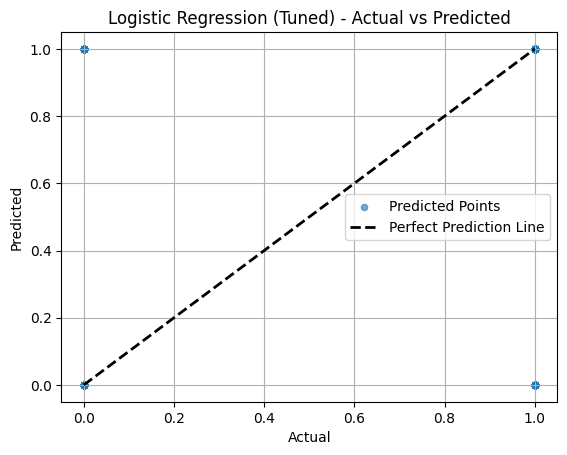

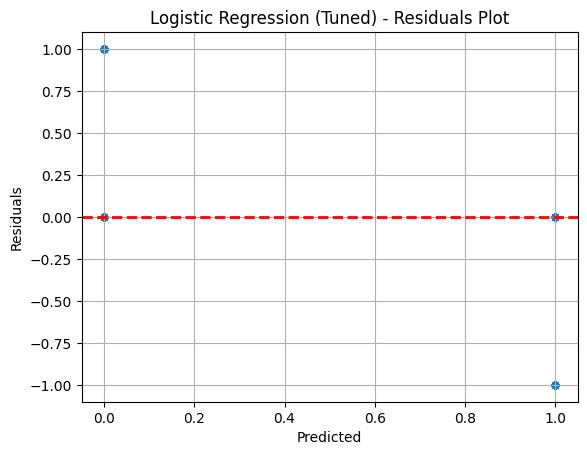

Accuracy: 0.8371
Precision: 0.8416
Recall: 0.8306
F1: 0.8361
ROC-AUC: 0.9216

Confusion Matrix:
  Predicted:  Loss | Win
Actual Loss:  259 |  48
Actual Win:    52 | 255

Feature Coefficients:
  FG: 1.3683
  FGA: -2.5107
  3P: 1.3876
  3PA: -0.3581
  FT: -0.3271
  FTA: 0.4189
  ORB: 0.8788
  DRB: 1.0047
  TRB: 1.3412
  AST: 0.1713
  STL: 1.3994
  BLK: 0.5331
  TOV: -1.5157
  PF: 0.0397
  MP: -0.2008
  team_fg_pct: 0.7131
  team_3p_pct: -0.3303
  team_ft_pct: 0.6274

--------------------------------------------------------------------------------
Model: Random Forest (Tuned)
--------------------------------------------------------------------------------


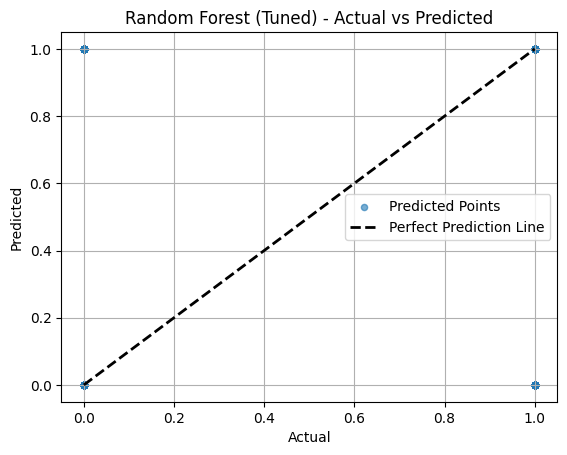

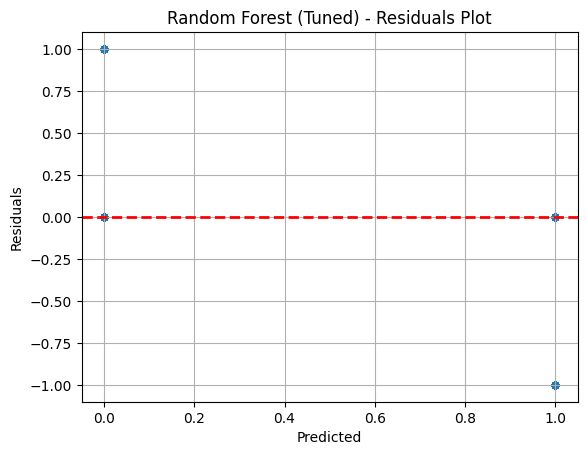

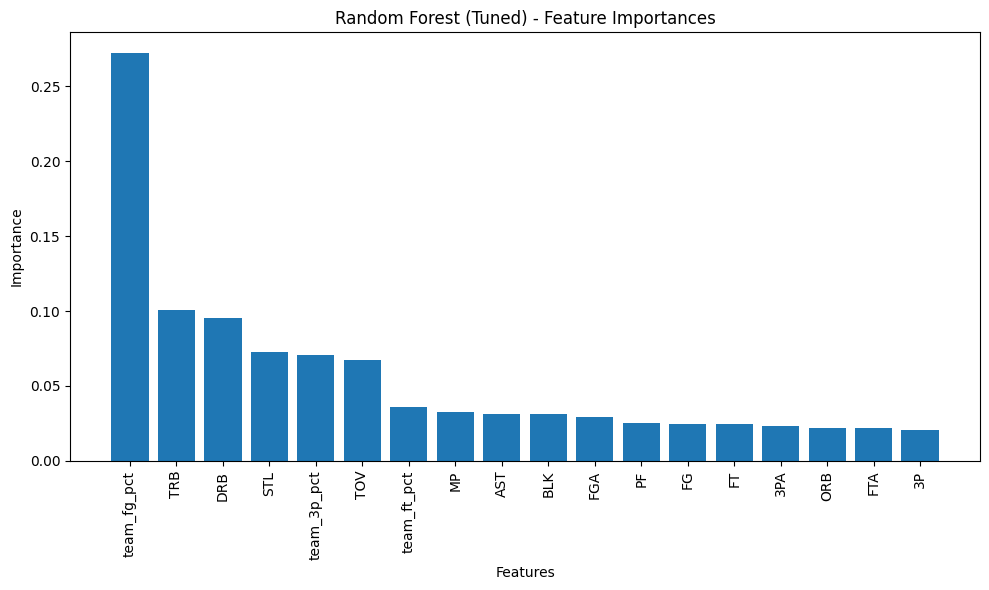

Accuracy: 0.7899
Precision: 0.7853
Recall: 0.7980
F1: 0.7916
ROC-AUC: 0.8660

Confusion Matrix:
  Predicted:  Loss | Win
Actual Loss:  240 |  67
Actual Win:    62 | 245

Feature Importances:
  FG: 0.0246
  FGA: 0.0293
  3P: 0.0206
  3PA: 0.0231
  FT: 0.0246
  FTA: 0.0218
  ORB: 0.0218
  DRB: 0.0951
  TRB: 0.1006
  AST: 0.0312
  STL: 0.0725
  BLK: 0.0310
  TOV: 0.0671
  PF: 0.0254
  MP: 0.0327
  team_fg_pct: 0.2722
  team_3p_pct: 0.0707
  team_ft_pct: 0.0357

--------------------------------------------------------------------------------
Model: Gradient Boosting (Tuned)
--------------------------------------------------------------------------------


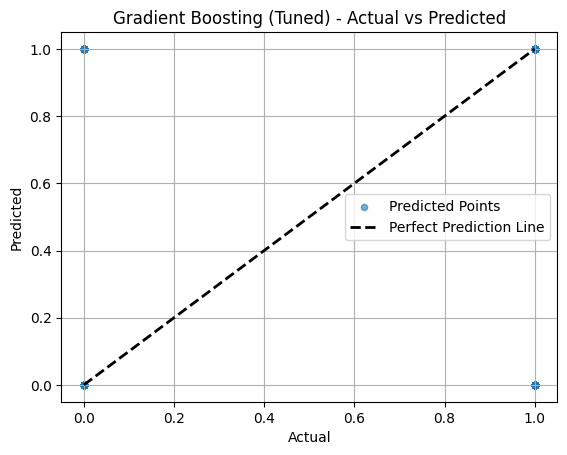

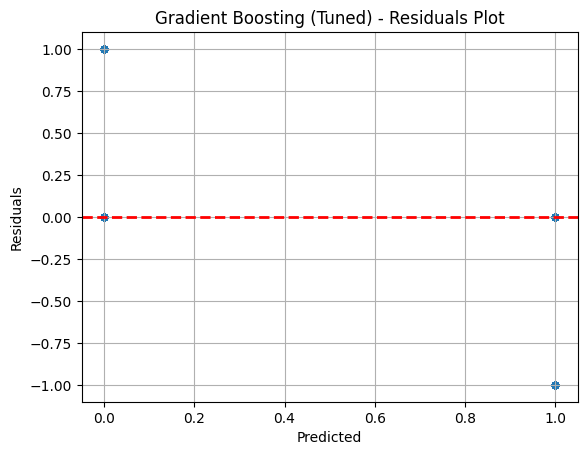

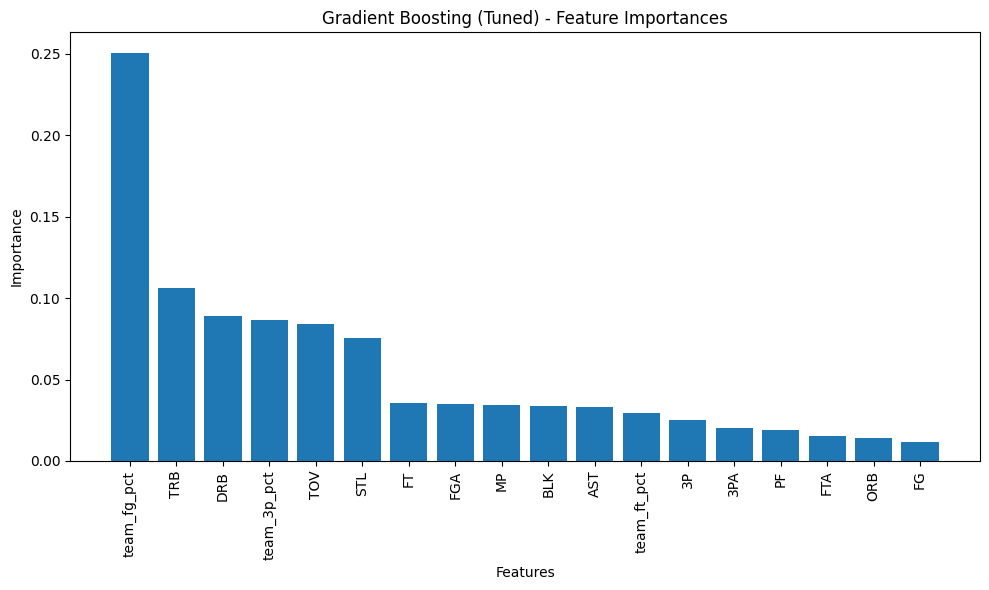

Accuracy: 0.8111
Precision: 0.8111
Recall: 0.8111
F1: 0.8111
ROC-AUC: 0.8925

Confusion Matrix:
  Predicted:  Loss | Win
Actual Loss:  249 |  58
Actual Win:    58 | 249

Feature Importances:
  FG: 0.0119
  FGA: 0.0352
  3P: 0.0254
  3PA: 0.0201
  FT: 0.0356
  FTA: 0.0152
  ORB: 0.0143
  DRB: 0.0891
  TRB: 0.1060
  AST: 0.0332
  STL: 0.0756
  BLK: 0.0340
  TOV: 0.0842
  PF: 0.0190
  MP: 0.0345
  team_fg_pct: 0.2507
  team_3p_pct: 0.0866
  team_ft_pct: 0.0294

--------------------------------------------------------------------------------
Model: Logistic Regression
--------------------------------------------------------------------------------


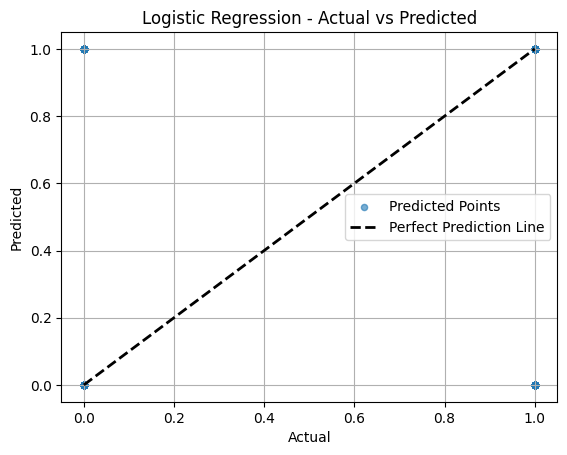

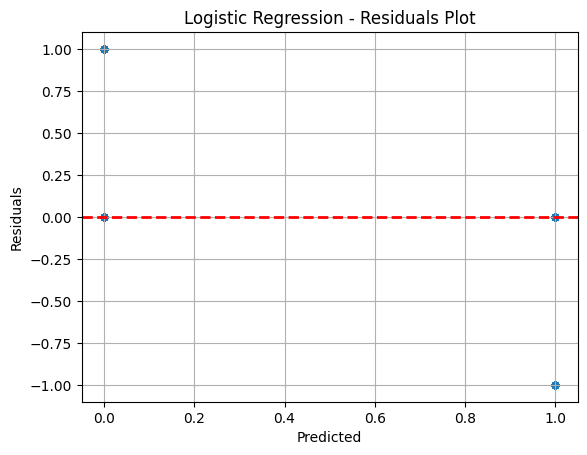

Accuracy: 0.8436
Precision: 0.8505
Recall: 0.8339
F1: 0.8421
ROC-AUC: 0.9208

Confusion Matrix:
  Predicted:  Loss | Win
Actual Loss:  262 |  45
Actual Win:    51 | 256

Feature Coefficients:
  FG: 0.5745
  FGA: -1.8381
  3P: 0.9303
  3PA: -0.1143
  FT: -0.0514
  FTA: 0.1723
  ORB: 0.7974
  DRB: 0.9519
  TRB: 1.2502
  AST: 0.1712
  STL: 1.3139
  BLK: 0.5043
  TOV: -1.4120
  PF: 0.0249
  MP: -0.1852
  team_fg_pct: 1.3257
  team_3p_pct: -0.0044
  team_ft_pct: 0.5012

--------------------------------------------------------------------------------
Model: Random Forest
--------------------------------------------------------------------------------


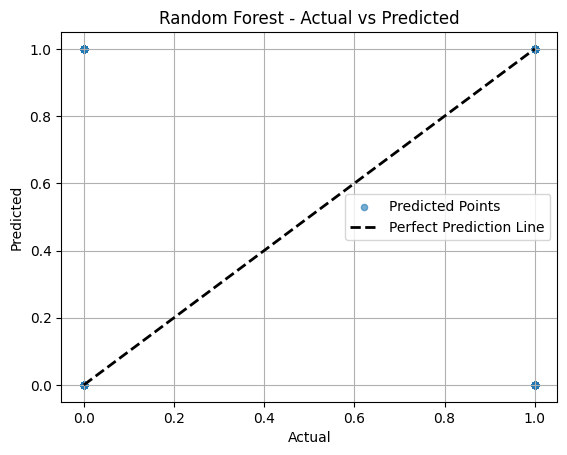

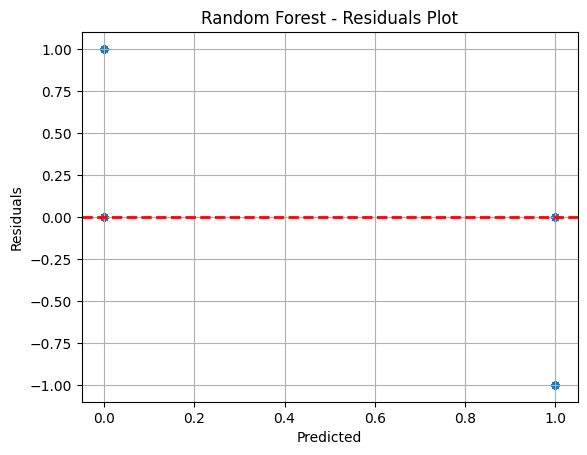

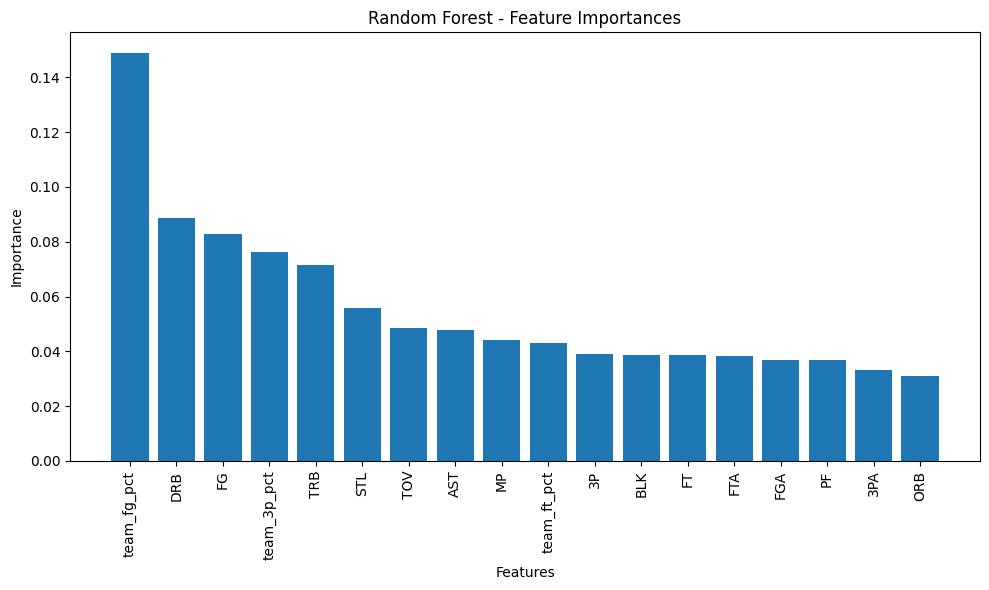

Accuracy: 0.7899
Precision: 0.7764
Recall: 0.8143
F1: 0.7949
ROC-AUC: 0.8707

Confusion Matrix:
  Predicted:  Loss | Win
Actual Loss:  235 |  72
Actual Win:    57 | 250

Feature Importances:
  FG: 0.0826
  FGA: 0.0369
  3P: 0.0392
  3PA: 0.0330
  FT: 0.0385
  FTA: 0.0382
  ORB: 0.0311
  DRB: 0.0888
  TRB: 0.0714
  AST: 0.0479
  STL: 0.0557
  BLK: 0.0386
  TOV: 0.0486
  PF: 0.0369
  MP: 0.0441
  team_fg_pct: 0.1490
  team_3p_pct: 0.0763
  team_ft_pct: 0.0431

--------------------------------------------------------------------------------
Model: Gradient Boosting
--------------------------------------------------------------------------------


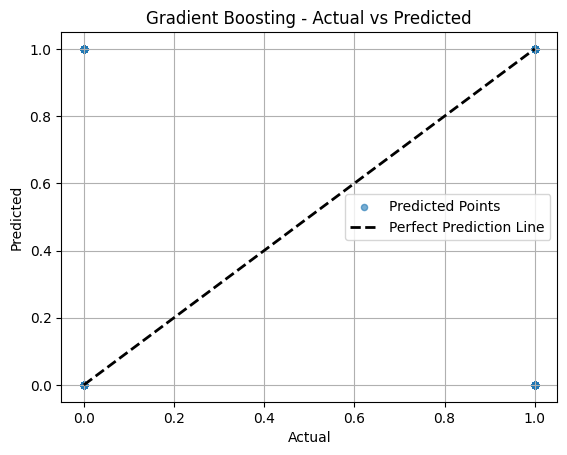

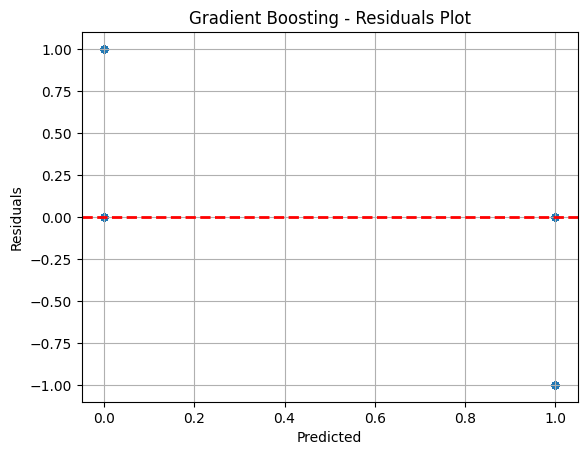

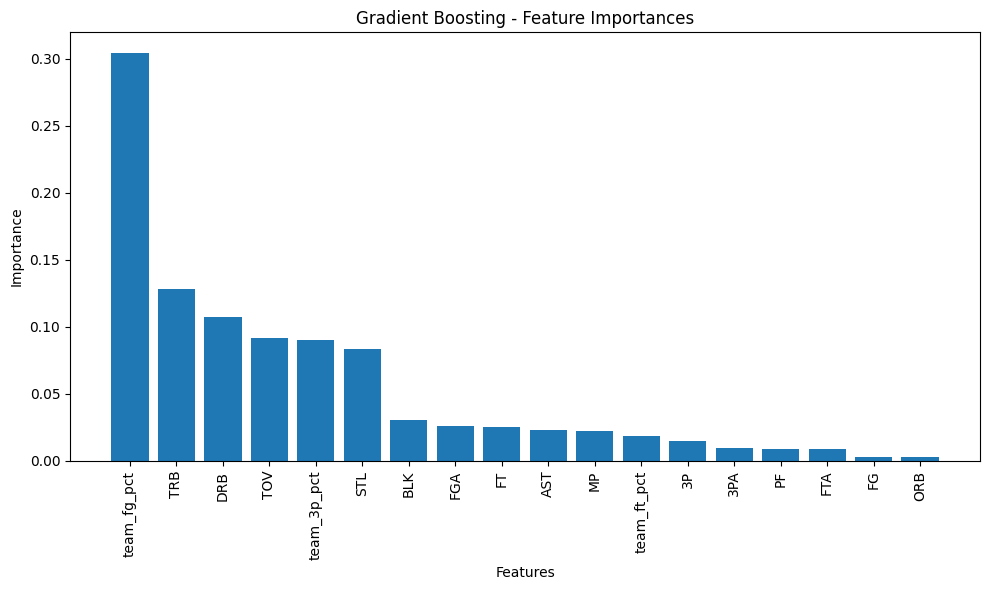

Accuracy: 0.8062
Precision: 0.7975
Recall: 0.8208
F1: 0.8090
ROC-AUC: 0.8925

Confusion Matrix:
  Predicted:  Loss | Win
Actual Loss:  243 |  64
Actual Win:    55 | 252

Feature Importances:
  FG: 0.0031
  FGA: 0.0262
  3P: 0.0149
  3PA: 0.0099
  FT: 0.0251
  FTA: 0.0088
  ORB: 0.0029
  DRB: 0.1070
  TRB: 0.1285
  AST: 0.0234
  STL: 0.0832
  BLK: 0.0309
  TOV: 0.0915
  PF: 0.0089
  MP: 0.0222
  team_fg_pct: 0.3044
  team_3p_pct: 0.0901
  team_ft_pct: 0.0190

SUMMARY OF RESULTS FOR win

                      Accuracy   Precision    Recall        F1   ROC-AUC
Logistic Regression (Tuned)    0.8371      0.8416    0.8306    0.8361    0.9216
Random Forest (Tuned)    0.7899      0.7853    0.7980    0.7916    0.8660
Gradient Boosting (Tuned)    0.8111      0.8111    0.8111    0.8111    0.8925
Logistic Regression     0.8436      0.8505    0.8339    0.8421    0.9208
Random Forest           0.7899      0.7764    0.8143    0.7949    0.8707
Gradient Boosting       0.8062      0.7975    0.8208    0.

({'Logistic Regression (Tuned)': {'Accuracy': 0.8371335504885994,
   'Precision': 0.8415841584158416,
   'Recall': 0.8306188925081434,
   'F1': 0.8360655737704918,
   'ROC-AUC': 0.9216331207758173},
  'Random Forest (Tuned)': {'Accuracy': 0.7899022801302932,
   'Precision': 0.7852564102564102,
   'Recall': 0.7980456026058632,
   'F1': 0.7915993537964459,
   'ROC-AUC': 0.8660410190028541},
  'Gradient Boosting (Tuned)': {'Accuracy': 0.8110749185667753,
   'Precision': 0.8110749185667753,
   'Recall': 0.8110749185667753,
   'F1': 0.8110749185667753,
   'ROC-AUC': 0.8924550923617226},
  'Logistic Regression': {'Accuracy': 0.8436482084690554,
   'Precision': 0.8504983388704319,
   'Recall': 0.8338762214983714,
   'F1': 0.8421052631578947,
   'ROC-AUC': 0.9208055257880721},
  'Random Forest': {'Accuracy': 0.7899022801302932,
   'Precision': 0.7763975155279503,
   'Recall': 0.8143322475570033,
   'F1': 0.794912559618442,
   'ROC-AUC': 0.8707413341255611},
  'Gradient Boosting': {'Accuracy': 

In [5]:
training.predict_target(team_stats_df, 'win', classification=True)